# Binary Classification Model - With Data Augmentation

Now that we created a simple model and seen the performance of the task, we can now use data augmentation to check if the performance can be increased.

The augmentation presented is extremelly important given that it increases the amount of training data and makes more difficult for the model to just memorize the training data (overfitting the model)



> Drive with files: https://drive.google.com/drive/folders/1l_thkTxtzfkN6Nifjilnvb3909TIX8QH?usp=share_link



In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL_HW1

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

images = np.load('clean_images.npy', allow_pickle=True)  #shape (5004,96,96,3)
labels = np.load('clean_labels.npy', allow_pickle=True)  #shape (5004,)

Mounted at /gdrive
[Errno 2] No such file or directory: '/gdrive/My Drive/AN2DL_HW1'
/content
2.14.0


FileNotFoundError: ignored

## Data Preparation

Just like said in the last notebook, in order to avoid data leakage, lets split the dataset now. Lets set 500 samples for validation, 500 for test and the rest we'll use for training. Let's not forget to split the data in a stratified manner, given that there's a clear dataset imbalance.

In [ ]:
X = images.copy()
y = labels.copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=500,
                                                            random_state=42, stratify=y)

# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (4504, 96, 96, 3)
Training-Validation Label Shape: (4504,)
Test Data Shape: (500, 96, 96, 3)
Test Label Shape: (500,)


In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=500, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (4004, 96, 96, 3)
Training Label Shape: (4004,)
Validation Data Shape: (500, 96, 96, 3)
Validation Label Shape: (500,)


In [ ]:
# bounding of the values, just like before
import tensorflow as tf
X_test = tf.cast(X_test/255.0, tf.float32)
X_val = tf.cast(X_val/255.0, tf.float32)
X_train = tf.cast(X_train/255.0, tf.float32)

## Model Architecture

The given model is quite similar to the one presented before without augmentation, however, it has some changes.

Due to the increase in quantity and variety of data given by the augmentation, the previous model was too simple to understand the general patterns. Therefore, some of the Dropout layers defined before were droppen in the attempt of making the model provide better results.

In [3]:
input_shape = (96,96,3)

model = tfk.models.Sequential()

model.add(tfkl.Input(shape=input_shape, name='Input'))


#adding preprocessing layers
model.add(tfkl.RandomFlip("horizontal"))
model.add(tfkl.RandomRotation(0.2))
model.add(tfkl.RandomBrightness(0.2, value_range=(0,1)))
model.add(tfkl.RandomTranslation(0.2,0.2))
model.add(tfkl.RandomZoom(0.2))
model.add(tfkl.RandomContrast(0.75))


#convolutional layers
model.add(tfkl.Conv2D(128, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
# model.add(tfkl.Dropout(0.2))     # removed dropout layers

model.add(tfkl.Conv2D(128, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
# model.add(tfkl.Dropout(0.2))     # removed dropout layers

model.add(tfkl.Conv2D(128, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Conv2D(128, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Conv2D(64, (3, 3), activation='relu'))
model.add(tfkl.MaxPooling2D())
model.add(tfkl.Dropout(0.2))

model.add(tfkl.BatchNormalization())


#fully-connected layers
model.add(tfkl.Flatten())

model.add(tfkl.Dense(512, activation='relu'))
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Dense(128, activation='relu'))
model.add(tfkl.Dropout(0.2))

model.add(tfkl.Dense(64, activation='relu'))
model.add(tfkl.BatchNormalization())

model.add(tfkl.Dense(1, activation='sigmoid'))

In [4]:
# the learning rate was increased with the objective to make more rapid changes

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'], loss = tfk.losses.BinaryCrossentropy())
calls = tfk.callbacks.EarlyStopping(patience=25, verbose=1, restore_best_weights=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.4 MB/s eta 0:00:00


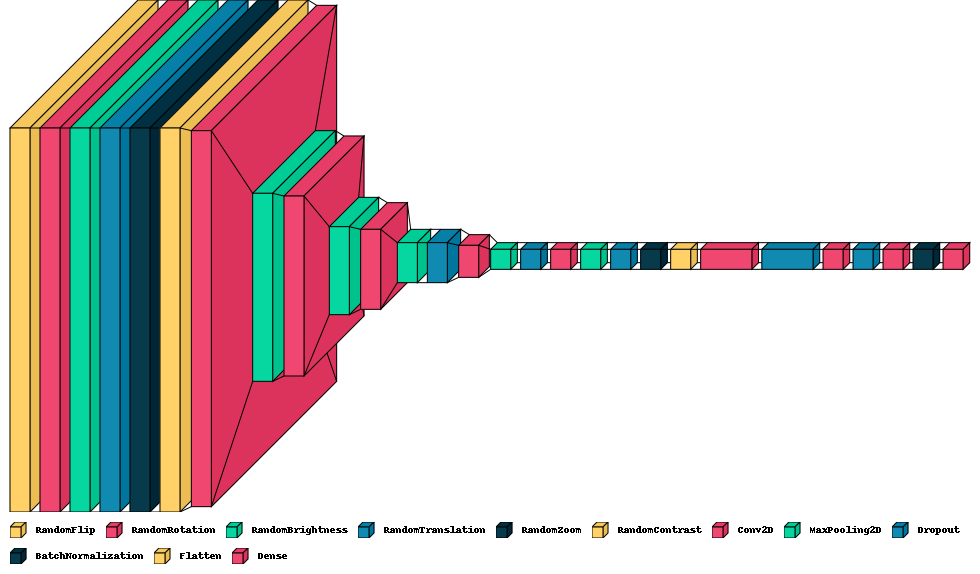

In [7]:
!pip install visualkeras
from PIL import ImageFont
import visualkeras
visualkeras.layered_view(model, legend=True)  # font is optional!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 96, 96, 3)         0         
                                                                 
 random_rotation (RandomRot  (None, 96, 96, 3)         0         
 ation)                                                          
                                                                 
 random_brightness (RandomB  (None, 96, 96, 3)         0         
 rightness)                                                      
                                                                 
 random_translation (Random  (None, 96, 96, 3)         0         
 Translation)                                                    
                                                                 
 random_zoom (RandomZoom)    (None, 96, 96, 3)         0         
                                                        

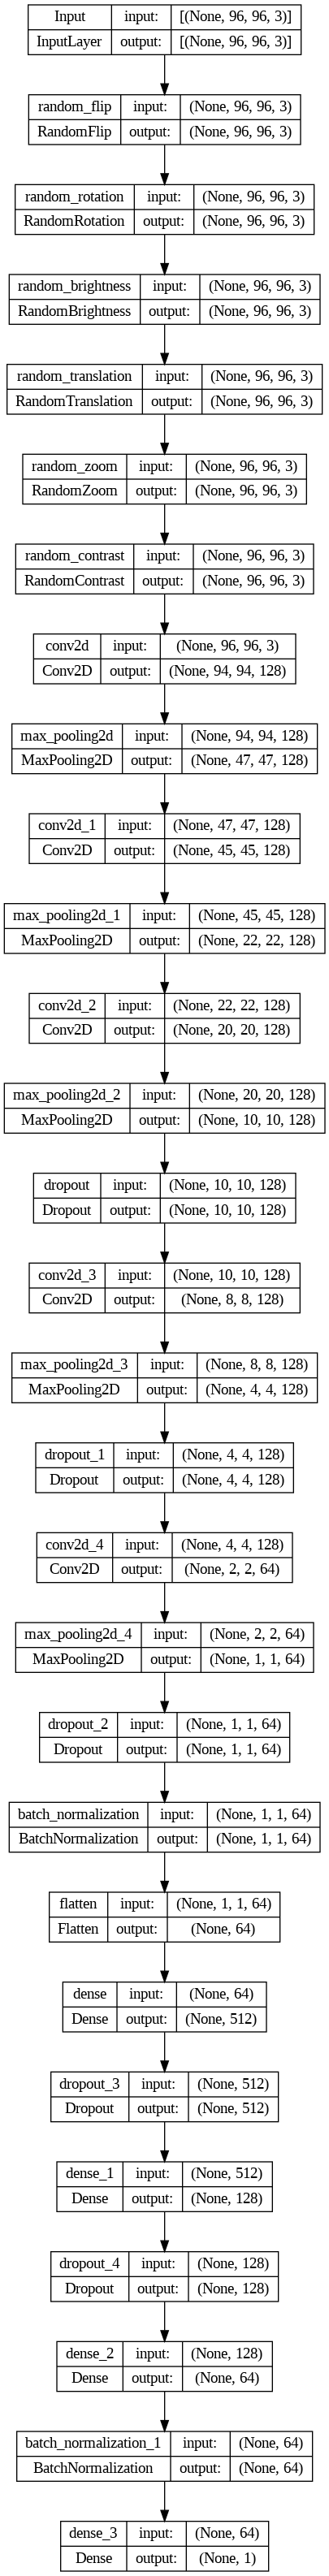

In [5]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
batch_size = 32
epochs = 200

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [calls]
).history

Epoch 1/200
126/126 [==============================] - 342s 3s/step - loss: 0.7007 - accuracy: 0.5977 - val_loss: 0.9202 - val_accuracy: 0.6200
Epoch 2/200
126/126 [==============================] - 342s 3s/step - loss: 0.6725 - accuracy: 0.6104 - val_loss: 0.8152 - val_accuracy: 0.6200
Epoch 3/200
126/126 [==============================] - 335s 3s/step - loss: 0.6730 - accuracy: 0.6151 - val_loss: 0.6911 - val_accuracy: 0.5140
Epoch 4/200
126/126 [==============================] - 346s 3s/step - loss: 0.6655 - accuracy: 0.6199 - val_loss: 0.6977 - val_accuracy: 0.5620
Epoch 5/200
126/126 [==============================] - 338s 3s/step - loss: 0.6707 - accuracy: 0.6156 - val_loss: 0.6642 - val_accuracy: 0.6200
Epoch 6/200
126/126 [==============================] - 357s 3s/step - loss: 0.6677 - accuracy: 0.6114 - val_loss: 0.6728 - val_accuracy: 0.6160
Epoch 7/200
126/126 [==============================] - 344s 3s/step - loss: 0.6499 - accuracy: 0.6411 - val_loss: 0.6700 - val_accuracy:

In [ ]:
# saving model
model.save('Sequential_with_Aug')

below code taken from the lab sessions

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Load model
model = tfk.models.load_model('Sequential_with_augmentation')

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (500, 1)


Accuracy: 0.62
Precision: 0.0
Recall: 0.0
F1: 0.0


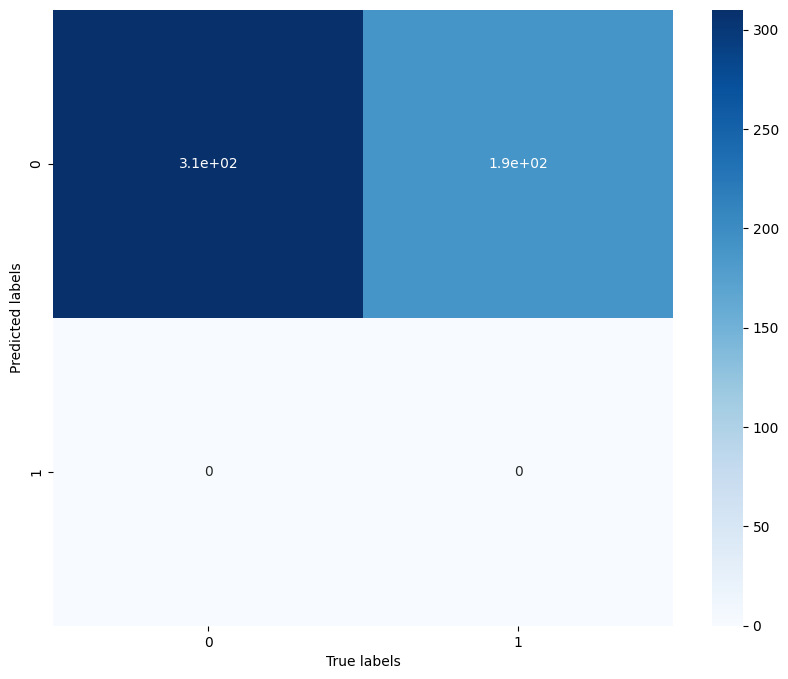

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions.round())

# Compute classification metrics
accuracy = accuracy_score(y_test, predictions.round())
precision = precision_score(y_test, predictions.round())
recall = recall_score(y_test, predictions.round())
f1 = f1_score(y_test, predictions.round())

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Conclusions

As we can see here, its possible to realize that, the performance increased due to the Augmentation, proving it to be a valuable technique to inprove the model generalization procedures.

The approaches taken failed to consider a very important aspect: leaf identification is not a new problem, there are many already built neural networks created for this and similar purpose and trained with much more data than we have. Given this, the next steps in the development consist on the creation neural networks with Transfer Learning.